<a href="https://colab.research.google.com/github/banucicek/DevDataProd_PeerAssessment1/blob/master/Trendyol_DataScience_CS2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feedback from Trendyol on 20201026: 

*   better handling of peak events
*   emphasis on trend and seasonality



For performing this analysis, please use following data sources:

productDailyActions.csv: 
You are expected to split this file into train and test dataset. It contains following informations for the dates between '2018-11-01' and '2019-01-12':
- productid: unique id for each product
- date: date of product action 
- soldquantity : sales of product
- stock : beginning stock count of product
- clickcount : # of clicks of product
- favoredcount: # of favored click of product

productAttributes.csv:
This file contains product related informations belonging to each product id. The file contains following informations: productid, gender, color, categoryid, brandid, subcategoryid. 

Objectives:
We are asking you to build an algorithm(s) that can forecast the sales of any  product for next day. Please prepare the presentation with your results. In it, you’ll have to justify and explain:

•	How did you create the target variable?

•	How did you prepare the final dataset for modeling?

•	How did you split datasets into training and testing?

•	What methods did you use for modelling and why?

•	How did you quantify the performance of your model(s)?

You need to be ready to explain all the assumptions that you made.
Together with your presentation (in PDF/Excel) you'll need to provide us with your source code written in Python/R/Spark.


In [ ]:
# importing necesary libraries
import pandas as pd
print('pandas: %s' % pd.__version__)
import numpy as np
print('numpy: %s' % np.__version__)
from math import sqrt
import matplotlib.pyplot as plt
import datetime

from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error





pandas: 1.0.5
numpy: 1.18.5


In [ ]:
# Not necessary if running on local
# File upload on colabs,
# running_on_server = True
# # upload the files first, if running on server
# if running_on_server:
#   from google.colab import files
#   uploaded = files.upload()

In [ ]:
# read in the datasets
product_attributes = pd.read_csv('productAttributes.csv')
product_daily_actions = pd.read_csv('productDailyActions.csv')
# convert date column to date type
product_daily_actions['date'] = pd.to_datetime(product_daily_actions['date'])

In [ ]:
product_attributes.dtypes

productid        int64
gender           int64
color            int64
categoryid       int64
brandid          int64
subcategoryid    int64
price            int64
dtype: object

In [ ]:
product_daily_actions.dtypes

productid                int64
date            datetime64[ns]
soldquantity             int64
stock                    int64
clickcount             float64
favoredcount           float64
dtype: object

In [ ]:
product_attributes.nunique()

productid        19359
gender               3
color             2243
categoryid         101
brandid            868
subcategoryid      103
price             1950
dtype: int64

In [ ]:
product_attributes.shape

(19359, 7)

In [ ]:
product_daily_actions.shape

(858935, 6)

In [ ]:
product_attributes.head()

,productid,gender,color,categoryid,brandid,subcategoryid,price
0,81,2,4893,407,390,20,2114
1,121,1,1684,411,390,23,1851
2,141,2,5414,434,390,56,2236
3,161,2,3500,411,390,23,1851
4,181,2,6784,1825,390,68,1421


In [ ]:
product_daily_actions.head()

,productid,date,soldquantity,stock,clickcount,favoredcount
0,1,2018-11-23,0,140,82.0,NaN
1,21,2018-11-30,0,3,11.0,NaN
2,21,2018-12-27,0,2,2.0,NaN
3,21,2019-01-09,0,2,2.0,1.0
4,21,2018-12-18,0,2,5.0,NaN


In [ ]:
# check if products are unique
assert len(product_attributes['productid'].unique()) == product_attributes.shape[0]

In [ ]:
# check if there are any missing values in the table
assert product_attributes.isna().any(axis=1).sum() == 0

In [ ]:
# check if product ids in two datasets correspond
assert set(product_daily_actions['productid'].unique()) == set(product_attributes['productid'].unique())

In [ ]:
# check if there are any duplicates of <productid, date> pair
assert product_daily_actions[['productid', 'date']].duplicated().any() == False

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd1fbce41d0>]],
      dtype=object)

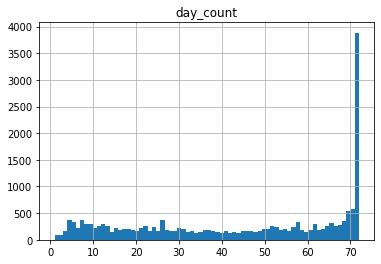

In [ ]:
# Number of days that the product has entry in daily actions tale
per_product_id = product_daily_actions.groupby('productid')[['date']].count().sort_values(by='date').rename(columns={'date': 'day_count'})
per_product_id.hist(bins=per_product_id['day_count'].max())

In [ ]:
# Date gaps
date_gap_check_df = product_daily_actions[['productid', 'date']].sort_values(by=['productid', 'date'])
date_gap_check_df['deltas'] = date_gap_check_df['date'].diff()[1:]
date_gap_check_df.sort_values(['deltas'], ascending=False).head()

,productid,date,deltas
497365,78171,2019-01-11,70 days
507713,147191,2019-01-09,65 days
275570,82421,2019-01-04,64 days
326496,99421,2019-01-11,63 days
171308,56911,2019-01-05,63 days


In [ ]:
# identify columns with missing values
product_daily_actions.isna().any()

productid       False
date            False
soldquantity    False
stock           False
clickcount       True
favoredcount     True
dtype: bool

In [ ]:
# chosen imputation method: fill with zero, since it makes sense to treat the missing count values as zero count
product_daily_actions.fillna(0, inplace=True)

In [ ]:
def extract_attribute_features(merged_df, groupby_attributes, pred_date):
  # summarize daily actions according to product's attributes we are interested in 
  merged_df['sold_any'] = merged_df['soldquantity'].astype(bool)

  # the_attributes = product_attributes.loc[product_attributes['productid']==product_id][list_of_attributes]
  output_df = merged_df[groupby_attributes].drop_duplicates()

  # for all history
  # total number of days that there products for list_of_attributes were sold
  # total number of sales for list_of_attributes
  # average number of sales for list_of_attributes
  # maximum number of sales for list_of_attributes
  aggregated_df = merged_df.groupby(groupby_attributes).agg(
                           {
                               'sold_any': 'sum',
                               'soldquantity': ['sum', 'mean', 'max']
                               })
  # name columns accordingly
  aggregated_df.columns = aggregated_df.columns.map('_'.join)
  groupby_attr_as_string = '_'.join(groupby_attributes)
  aggregated_df.columns = [n + '_' + groupby_attr_as_string for n in aggregated_df.columns]

  output_df = pd.merge(output_df, 
                       aggregated_df.reset_index(),
                       on=groupby_attributes,
                       how='left')
  
  # TODO: for the last week
  # TODO: for the day of week
  return output_df


In [ ]:
def prepare_dateset(product_attributes, product_daily_actions, pred_date=datetime.datetime.today()):
  # prepares the input dataframe for all the products in the first dataframe, for the given prediction_date

  # filter in only the data which is prior to the prediction date
  historic_daily_actions = product_daily_actions.loc[product_daily_actions['date']<pred_date]

  # initiate product-based model input data frame
  df = product_attributes

  # daily actions summarization according to diffrent combinations of product attributes
  # merge product attributes to daily actions data
  merged_df = pd.merge(historic_daily_actions, product_attributes, how='left', on='productid')
  # as an example I chose [brandid, gender]
  brandid_gender_features = extract_attribute_features(merged_df=merged_df, 
                                                       groupby_attributes=['brandid', 'gender'],
                                                       pred_date=pred_date)
  # merge summary features to our model input data frame
  df = pd.merge(df, brandid_gender_features, on=['brandid', 'gender'], how='left')

  # get the date of t-1
  t_1 = pred_date + datetime.timedelta(days=-1)

  for i in df.index: # for each product
    # get the historic daily actions data belonging to the product
    historic_daily_actions_for_product = historic_daily_actions.loc[historic_daily_actions['productid']==i]
    # get the last date tha the product had daily actions data entry
    last_date_for_product = historic_daily_actions_for_product['date'].max()
    try:
      # get the last daily actions entry for the product
      last_entry = historic_daily_actions_for_product.loc[historic_daily_actions_for_product['date']==last_date_for_product]
      # extract feature: number of days passed since the last entry
      df.loc[i, 'day_passed_since_last_record'] = (pred_date - last_date_for_product).days
      # extract feature: last observed stock count prior to prediction date
      df.loc[i, 'stock'] = last_entry['stock'].values
    except:
      # if no historic entry for product, fill with the representative of the missing value
      df.loc[i, 'day_passed_since_last_record'] = -1
      df.loc[i, 'stock'] = 0
    if df.loc[i, 'day_passed_since_last_record'] ==1: # if the product had daily actions entry for the previous day
      # get the daily actions entry for the product for the day before the prediction date
      t_1_entry = historic_daily_actions_for_product.loc[historic_daily_actions_for_product['date']==t_1]
      # extract feature: previous day's sold quantity
      df.loc[i, 'sold_quantity_t_1'] = t_1_entry['soldquantity'].values
      # extract feature: previous day's click count
      df.loc[i, 'click_count_t_1'] = t_1_entry['clickcount'].values
      # extract feature: previous day's favored count
      df.loc[i, 'favored_count_t_1'] = t_1_entry['favoredcount'].values
    else: # if no entry for the previous day
      df.loc[i, 'sold_quantity_t_1'] = 0
      df.loc[i, 'click_count_t_1'] = 0
      df.loc[i, 'favored_count_t_1'] = 0
    
    # determine the target variable for model training for the given prediction day
    try:
      target_entry = product_daily_actions.loc[(product_daily_actions['productid']==i) & 
                                               (product_daily_actions['date']==pred_date)]
      df.loc[i, 'sold_quantity'] = target_entry['soldquantity'].values
    except:
      df.loc[i, 'sold_quantity'] = 0

  # drop raw attributes columns, as they are numeric representation of categorical values except for price
  columns_to_drop = product_attributes.columns.to_list()
  columns_to_drop.remove('price')
  columns_to_drop.remove('productid') 
  df = df.loc[:, [c for c in df.columns if not c in columns_to_drop]]

  return df.set_index('productid')

In [ ]:
def train_predict_evaluate(product_attributes, product_daily_actions, pred_date):
  # get the date of t-1
  t_1 = pred_date + datetime.timedelta(days=-1)

  # get training and test datasets
  training_df = prepare_dateset(product_attributes, product_daily_actions, pred_date=t_1)
  test_df = prepare_dateset(product_attributes, product_daily_actions, pred_date=pred_date)

  # split model input and output
  training_X = training_df.loc[:,training_df.columns != 'sold_quantity']
  training_X.fillna(0, inplace=True)
  training_y = training_df.loc[:,training_df.columns == 'sold_quantity']

  test_X = test_df.loc[:,test_df.columns != 'sold_quantity']
  test_X.fillna(0, inplace=True)
  test_y = test_df.loc[:,test_df.columns == 'sold_quantity']

  # scaling for SVR
  mm_scaler = preprocessing.MinMaxScaler()
  training_X_scaled = mm_scaler.fit_transform(training_X)
  test_X_scaled = mm_scaler.transform(test_X)

  # various models to try, with some hyperparameter tuning
  models = {'SVR1000_02': SVR(kernel='rbf', C=1000, gamma=0.2, epsilon=.1),
            'SVR100_01': SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1),
            'RFR6': RandomForestRegressor(n_estimators=6, random_state=0),
            'RFR10': RandomForestRegressor(n_estimators=10, random_state=0)}
  model_performances = []
  for key, m in models.items():
    if 'SVR' in key: # if SVR, use scaled input
      training_X = training_X_scaled
      test_X = test_X_scaled

    m_fit = m.fit(training_X, training_y.values.ravel()) 
    training_y_pred = m_fit.predict(training_X)
    test_y_pred = m_fit.predict(test_X)

    training_rmse = mean_squared_error(training_y, training_y_pred)
    test_rmse = mean_squared_error(test_y, test_y_pred)
    model_performances.append([key, training_rmse, test_rmse])
  return model_performances
    

In [ ]:
def shifting_window_evaluation(product_attributes, product_daily_actions, pred_dates):
  model_performances = pd.DataFrame()
  for pred_date in pred_dates:
    print(pred_date)
    mp = train_predict_evaluate(product_attributes, product_daily_actions, pred_date)
    mp_df = pd.DataFrame(mp, columns=['model', 'train_rmse', 'test_rmse'])
    mp_df['pred_date'] = pred_date
    model_performances = pd.concat([model_performances, mp_df])
    model_performances.append([pred_date].append(mp))
  return model_performances[['pred_date', 'model', 'train_rmse', 'test_rmse']]

In [ ]:
# date arrangement for shifting windows evaluation
historic_data_end_date = product_daily_actions['date'].max()
prediction_date = historic_data_end_date + datetime.timedelta(days=1)
shifting_window_start_date = historic_data_end_date + datetime.timedelta(days=-3)
shifting_window_end_date = historic_data_end_date

evaluation_dates = pd.date_range(start=shifting_window_start_date,
                            end=shifting_window_end_date,
                            freq='D')

In [ ]:
# shifting windows evaluation
performances = shifting_window_evaluation(product_attributes, product_daily_actions, evaluation_dates)


2019-01-08 00:00:00


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


2019-01-09 00:00:00


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


2019-01-10 00:00:00


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


2019-01-11 00:00:00


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [ ]:
# performances table for shifting windows evaluation
performances.groupby(['model']).mean().sort_values('test_rmse')

,train_rmse,test_rmse
model,,
RFR10,0.005150,0.027346
RFR6,0.006140,0.028084
SVR100_01,0.027629,0.030003
SVR1000_02,0.028217,0.033713


In [ ]:
# OUTPUT: predictions for '2019-01-12 with the chosen model
pred_date = datetime.datetime(2019,1,12)

# get the date of t-1
t_1 = pred_date + datetime.timedelta(days=-1)

# get training and test datasets
training_df = prepare_dateset(product_attributes, product_daily_actions, pred_date=t_1)

# split model input and output
training_X = training_df.loc[:,training_df.columns != 'sold_quantity']
training_X.fillna(0, inplace=True)
training_y = training_df.loc[:,training_df.columns == 'sold_quantity']

# scaling
mm_scaler = preprocessing.MinMaxScaler()
training_X_scaled = mm_scaler.fit_transform(training_X)

# various models to try, with some hyperparameter tuning
models = {'SVR1000_02': SVR(kernel='rbf', C=1000, gamma=0.2, epsilon=.1),
          'SVR100_01': SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1),
          'RFR6': RandomForestRegressor(n_estimators=6, random_state=0),
          'RFR10': RandomForestRegressor(n_estimators=10, random_state=0)}

# choose the best model
model_name = performances.groupby(['model']).mean().sort_values('test_rmse').iloc[0].name
m = models.get(model_name)

if 'SVR' in model_name: # if SVR, use scaled input
      training_X = training_X_scaled
      test_X = test_X_scaled

m_fit = m.fit(training_X, training_y.values.ravel()) 
training_y_pred = m_fit.predict(training_X)

training_rmse = mean_squared_error(training_y, training_y_pred)


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [ ]:

# save the predictions
predictions = pd.DataFrame(data=training_y_pred, index=training_X.index, columns=[pred_date.strftime('%Y-%m-%d')])
output_file = pred_date.strftime('%Y-%m-%d') + '_predictions.csv'
predictions.to_csv(output_file, index=True)

print('Predictions for: ' + pred_date.strftime('%Y-%m-%d') + 
      '\nwith the training RMSE of: ' + str(training_rmse) + 
      '\nis saved to file: ' + output_file)

Predictions for: 2019-01-12
with the training RMSE of: 0.002257864559119789
is saved to file: 2019-01-12_predictions.csv


In [ ]:
predictions.sort_values(predictions.columns[0], ascending=False)

,2019-01-12
productid,
88701,5.4
71081,4.8
173901,3.9
100901,3.8
111841,3.6
...,...
45341,0.0
45331,0.0
45271,0.0
